Import stuff and initialize global parameters.

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import regularizers
from keras.layers import Conv2D, Flatten, Dense, LSTM, \
    MaxPooling2D, Dropout
from keras.models import Sequential
from keras.models import load_model

from common import cut_labels_for_video, extract_training_data, generate_multifile_conc, random_file_gen
from sklearn.metrics import explained_variance_score

IMAGE_SIZE = (64, 64, 3)

Using TensorFlow backend.


### Preprocessing labels to match video
Procedure:
* Use ffmpeg to cut the initial noise out of the video
* Run cut_labels_for_video with True
* Use ffmpeg to cut the tail end off the video
* Run cut_labels_for_video with False

In [5]:
video_file = "Data/20180109-181030651_c.h264"
label_file = "Data/20180109-181030651_clean.csv"

In [4]:
cut_labels_for_video(video_file, label_file, True)

Video len: 129724
Label len: 133440
Dropping 3716 lines from labels.
Video len postdrop: 129724


In [2]:
video_file_clean = "Data/20180109-181030651_clean.h264"
label_file_clean = "Data/Preprocessed/20180109-181030651_clean.csv"

In [3]:
cut_labels_for_video(video_file_clean, label_file_clean, False)

Video len: 127620
Label len: 129724
Dropping 2104 lines from labels.


### Generator stuff

In [3]:
video_names = ["20180110-134224447_clean.h264",
               "20180110-123728742_clean.h264",
               "20180109-181030651_clean.h264",
               "20180110-153443702_clean.h264",
               "20180110-155554501_clean.h264",
               "20180110-161513446_clean.h264",
               "20180110-164811649_clean.h264"
               ]

csv_names = ["20180110-134224447_clean.csv",
             "20180110-123728742_clean.csv",
             "20180109-181030651_clean.csv",
             "20180110-153443702_clean.csv",
             "20180110-155554501_clean.csv",
             "20180110-161513446_clean.csv",
             "20180110-164811649_clean.csv"
             ]

For converting from comma decimals to point decimals and removing FrameNo column.
Usually not needed unless you're dealing with fresh data.

In [4]:
data_gen = generate_multifile_conc(video_names, csv_names, batch_size=500, nr_batches=104)

### Prepping data for training


In [2]:
images, labels = extract_training_data("Data/Preprocessed/20180109-181030651_clean.h264", 
                                       "Data/Preprocessed/20180109-181030651_clean.csv", 
                                       IMAGE_SIZE)

31905


D:\RCSnail\common.py:103: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  training_labels = labels.loc[training_label_ids]


In [18]:
y_train = labels["Steering"]

# Convolutional network
Reading data as bundles and creating initial model.

In [4]:
def create_slim_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", activation='relu', input_shape=(64, 64, 3), 
                     kernel_regularizer=regularizers.l2(0.1),
                     activity_regularizer=regularizers.l1(0.1)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", activation='relu', 
                      kernel_regularizer=regularizers.l2(0.1),
                     activity_regularizer=regularizers.l1(0.1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(1, activation='linear', 
                      kernel_regularizer=regularizers.l2(0.1),
                     activity_regularizer=regularizers.l1(0.1)))

    model.compile(loss="mse", optimizer="adam")    
    return model


slim_model = create_slim_model()
slim_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
dropout_5 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 230404    
Total para

In [19]:
def create_thicc_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', input_shape=(64, 64, 3), 
                      kernel_regularizer=regularizers.l2(0.1),
                    activity_regularizer=regularizers.l1(0.1)))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', 
                      kernel_regularizer=regularizers.l2(0.1),
                     activity_regularizer=regularizers.l1(0.1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", activation='relu', 
                      kernel_regularizer=regularizers.l2(0.1),
                     activity_regularizer=regularizers.l1(0.1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", activation='relu', 
                      kernel_regularizer=regularizers.l2(0.1),
                     activity_regularizer=regularizers.l1(0.1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', 
                      kernel_regularizer=regularizers.l2(0.1),
                     activity_regularizer=regularizers.l1(0.1)))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', 
                      kernel_regularizer=regularizers.l2(0.1),
                     activity_regularizer=regularizers.l1(0.1)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(1, activation='linear', 
                      kernel_regularizer=regularizers.l2(0.1),
                     activity_regularizer=regularizers.l1(0.1)))

    model.compile(loss="mse", optimizer="adam")    
    return model


thicc_model = create_thicc_model()
thicc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 14, 14, 64)        0         
__________

In [ ]:
print(images.shape)
print(y_train.shape)


history = thicc_model.fit(images, y_train, batch_size=64, epochs=10, validation_split=0.04)

(31905, 64, 64, 3)
(31905, 6)
Train on 30628 samples, validate on 1277 samples
Epoch 1/10
 4672/30628 [===>..........................] - ETA: 816s - loss: 77344.5416

In [8]:
history = slim_model.fit(images, y_train, batch_size=64, epochs=10, validation_split=0.04)

Epoch 1/10
104/104 [==============================] - 370s - loss: 0.1364   
Epoch 2/10
104/104 [==============================] - 369s - loss: 0.0184   
Epoch 3/10
104/104 [==============================] - 369s - loss: 0.0045   
Epoch 4/10
104/104 [==============================] - 369s - loss: 0.0022   
Epoch 5/10
104/104 [==============================] - 369s - loss: 0.0014   
Epoch 6/10
104/104 [==============================] - 369s - loss: 9.6153e-04   
Epoch 7/10
104/104 [==============================] - 369s - loss: 7.4214e-04   
Epoch 8/10
104/104 [==============================] - 369s - loss: 5.1682e-04   
Epoch 9/10
104/104 [==============================] - 369s - loss: 4.4032e-04   
Epoch 10/10
104/104 [==============================] - 369s - loss: 3.3355e-04   


## Saving models
Saves the model into a file and loads it again.

In [9]:
thicc_model.save('.\Models\conv_thicc.h5')
slim_model.save('.\Models\conv_slim.h5')

del thicc_model
del slim_model

In [3]:
model_slim = load_model('.\Models\conv_dense_gear_bigdata.h5')

In [4]:
model_slim.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_276 (Conv2D)          (None, 62, 62, 32)        3488      
_________________________________________________________________
conv2d_277 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_278 (Conv2D)          (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_279 (Conv2D)          (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 6, 6, 64)          0         
__________

## Prediction analysis

In [55]:
test_images, test_labels = extract_training_data_as_stacked("Data/Preprocessed/20180110-161513446_clean.h264", 
                                                            "Data/Preprocessed/20180110-161513446_clean.csv", 
                                                            IMAGE_SIZE)

D:\Dropbox\1_Õppematerjalid\2_Magister\1_Semester\Tehisnärvivõrgud\Projekt\common.py:54: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  training_labels = labels.loc[training_label_ids]


### Convolutional network results
Testing prediction printout and graphs.

In [65]:
prediction = model_slim.predict(test_images)
prediction

array([[-0.12917838, -0.00919936,  0.6950047 ,  1.83781826],
       [-0.31336802,  0.0152058 ,  0.69531262,  1.94690311],
       [-0.08402598, -0.01086511,  0.5923655 ,  1.88858056],
       ..., 
       [ 0.01925875, -0.00502366,  0.93121231,  1.90505171],
       [ 0.07175405, -0.00666948,  0.99072045,  1.94697356],
       [ 0.11869617, -0.01310982,  0.99120468,  1.98064923]], dtype=float32)

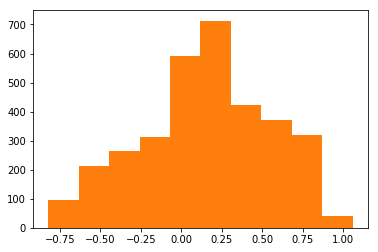

ValueError: max must be larger than min in range parameter.

In [66]:
# Prediction histogram
plt.hist(prediction[:, 0])
plt.show()

# Test data
plt.hist(test_labels['Steering'])
plt.show()

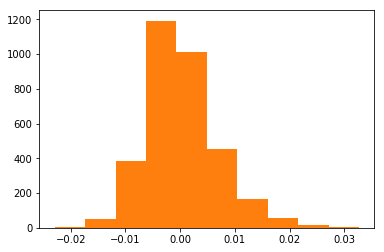

ValueError: max must be larger than min in range parameter.

In [58]:
# Prediction histogram
plt.hist(prediction[:, 1])
plt.show()

# Test data
plt.hist(test_labels['Braking'])
plt.show()

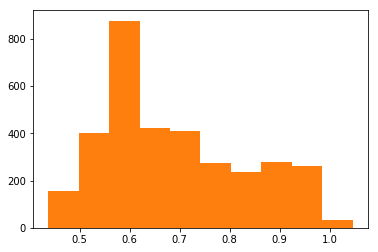

ValueError: max must be larger than min in range parameter.

In [59]:
# Prediction histogram
plt.hist(prediction[:, 2])
plt.show()

# Test data
plt.hist(test_labels['Throttle'])
plt.show()

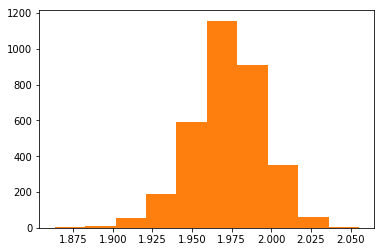

ValueError: max must be larger than min in range parameter.

In [60]:
# Prediction histogram
plt.hist(prediction[:, 3])
plt.show()

# Test data
plt.hist(test_labels['Gear'])
plt.show()

### Result analysis
Explained variance etc.

Firstly clip incorrect values back into known bounds. Afterwards find the explained variance.

In [11]:
validation_labels = test_labels.as_matrix(columns=test_labels.columns[1: ])

clipped_prediction = np.zeros_like(prediction)

# Steering
clipped_prediction[:, 0] = np.clip(prediction[:, 0], -1, 1)
# Brakes
clipped_prediction[:, 1] = np.clip(prediction[:, 1], 0, 1)
# Throttle
clipped_prediction[:, 2] = np.clip(prediction[:, 2], 0, 1)
# Gear
clipped_prediction[:, 3] = np.round(prediction[:, 3])


print(validation_labels.shape)
print(clipped_prediction.shape)

(3341, 4)
(3341, 4)


In [12]:
explained_variance_score(validation_labels, clipped_prediction)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## K fold cross validation

In [ ]:
from common import run_kfold_cross_val

# Concatenate both videos
total_images = np.concatenate((images, test_images), axis=0)
total_labels = np.concatenate((labels, test_labels), axis=0)

total_y_train = total_labels[:, 1:-1]

results = run_kfold_cross_val(create_model, total_images, total_y_train)
print(results)
print(results.mean())
print(np.median(results))